In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import networkx as nx
np.random.seed(123)

`shuffle`, `normalize` are unused but can be investigated further

In [2]:
N = 1000
t_max = 10000
f = np.empty((t_max, N)) # fitness value per species per timestep
f[0,:] = np.random.random(N)

def update(f, t=0, shuffle=False, normalize=False):
    f2 = f[t].copy()
    i = np.argmin(f2) # minimum
    i1 = (i - 1) % N # right neighbour
    i2 = (i + 1) % N # left neighbour
    if shuffle:
        indices = [j for j in range(N) if j not in [i, i1, i2]]
        f2 = list(f2[indices])
        for _ in range(3):
            # during this stage |f2| < N
            i = np.random.randint(0,len(f2))
            f2.insert(i, np.random.random())

        f2 = np.array(f2)

    else:
        f2[[i, i1, i2]] = np.random.random(3)

    if normalize:
        f2 = (f2 - np.min(f2)) * (np.max(f2) - np.min(f2))
    f[t+1,:] = f2

for t in range(t_max-1):
    update(f, t)

Text(0,0.5,'time')

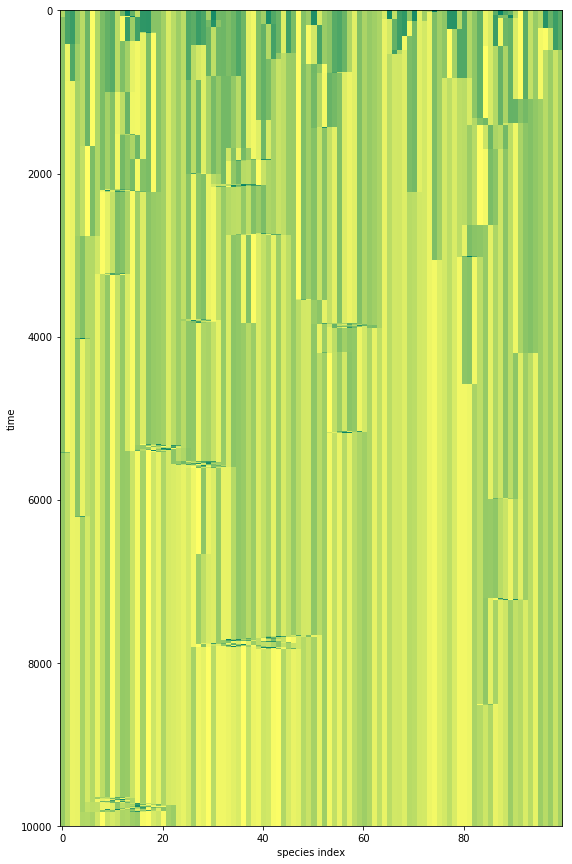

In [3]:
fig = plt.figure(figsize=(9,15))
# fig = plt.figure(figsize=(5,9))
i_max = 100
plt.imshow(np.array(f)[:,:i_max], cmap='summer', aspect='auto')
plt.xlabel('species index')
plt.ylabel('time')
# plt.semilogy()

Text(0.5,0,'species index (ordered by fitness)')

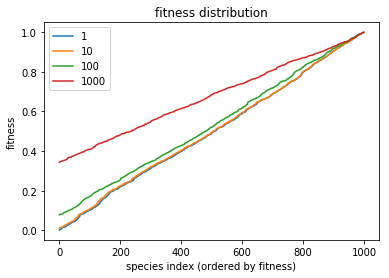

In [4]:
for i in np.logspace(0, np.log10(t_max), np.log10(t_max), endpoint=False, dtype=int):
    i = int(i)
    plt.plot(sorted(f[i]), label=i)
plt.legend()
plt.title('fitness distribution')
plt.ylabel('fitness')
plt.xlabel('species index (ordered by fitness)')

mean at t-max: 0.7853


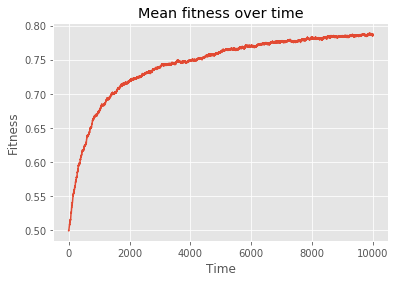

In [5]:
# Convergence of mean
# if True:
with plt.style.context(('ggplot')):
    plt.plot(np.mean(f, axis=-1))
    plt.title('Mean fitness over time')
    plt.ylabel('Fitness')
    plt.xlabel('Time')
#     plt.semilogy()
#     plt.semilogx()

print('mean at t-max: %0.4f' % np.mean(f, axis=-1)[-1])

## Using networkx

Text(0,0.5,'Time')

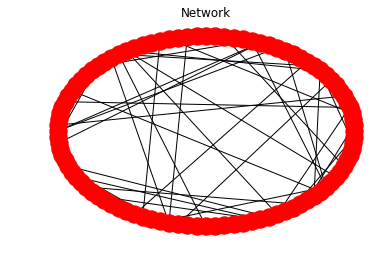

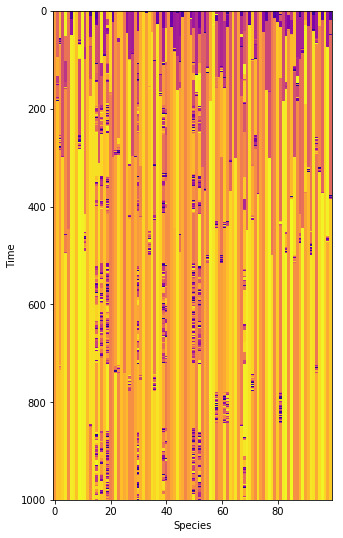

In [6]:
N = 100
t_max = 1000
f = np.empty((t_max, N)) # fitness value per species per timestep
f[0,:] = np.random.random(N)

# Create graph
g = nx.erdos_renyi_graph(N, 0.01)
# g = nx.watts_strogatz_graph(N, 3, 0.1)
# g = nx.barabasi_albert_graph(N, 1)

# perform Back-Sneppen
for t in range(t_max-1):
    i = np.argmin(f[t])
    idx = list(g[i])
    
    f[t+1] = f[t]
    f[t+1, i] = np.random.random()
    f[t+1, idx] = np.random.random(len(idx))
    
# plot
fig, ax = plt.subplots()
nx.draw_circular(g, with_labels=False)
ax.set_title("Network")

fig, ax = plt.subplots(figsize=(5,9))
ax.imshow(f[:,:], cmap="plasma", aspect="auto")
ax.set_xlabel("Species")
ax.set_ylabel("Time")

In [7]:
# class FitnessArray(np.ndarray):
#     def __new__(cls, keys, values):
#         # keys = species
#         # values = fitness values
        
#         obj = np.asarray(values).view(cls)
#         # add the new attribute to the created instance
#         obj.keys = keys
#         return obj

#     def __array_finalize__(self, obj):
#         # https://docs.scipy.org/doc/numpy/user/basics.subclassing.html
#         # see InfoArray.__array_finalize__ for comments
# #         if obj is None: return
#         self.info = getattr(obj, 'info', None)    

# FitnessArray([1,2,3], [3,3,4])

FitnessArray([3, 3, 4])

In [144]:
class Iterator:
    def __init__(self, start):
        self.next = start
        
    def get_next(self):
        self.next += 1
        return self.next - 1

N = 3
N2 = N**2
t_max = 100
N_species = 10
degree = 3
degree2 = np.ceil(degree/2).astype(int)
g = nx.erdos_renyi_graph(N_species, 0.01, seed=123, directed=False)

# g = nx.watts_strogatz_graph(N, 3, 0.1)
# g = nx.barabasi_albert_graph(N, 1)
grid = nx.lattice.grid_2d_graph(N, N, periodic=False)

# init species over spatial lattice
# note that the fitness is defined locally: it always depends on the environment
# f = np.empty((t_max, N2), dtype=object) # fitness value per species per location per timestep
grid_species = np.empty((t_max+1, N2), dtype=object) # species per location per timestep

# init species
species = list(range(N_species))
f_global = {k: np.random.random() for k in species}

N_species_max = int(1e3)
# fitness_per_timestep = np.empty((t_max+1, len(f_global.keys())))
fitness = np.zeros((t_max+1, N2, N_species_max))

# init each location with all species
for i in range(N2):
#     f[0,i] = FitnessArray(np.arange(N_species), np.random.random(N_species))
    grid_species[0,i] = species.copy()

identifier_iter = Iterator(start=species[-1])


def local_fitness(k, t, loc, g):
    f = f_global[k]
    dependency_ratio = 1 if any([k2 in grid_species[t, loc] for k2 in g[k]]) else 0
    return f * dependency_ratio

# Back-Sneppen iteration
for t in range(grid_species.shape[0]-1):
    f = np.array(list(f_global.values()))    
    if t % 100 == 0:
        # TODO cleanup species from graph
        0

    for loc in range(grid_species.shape[1]):
        species_local = grid_species[t, loc].copy()
        for i, k in enumerate(species_local):
            if i < N_species_max:
                fitness[t, loc, i] = f_global[k]
        
        i = np.argmin([local_fitness(k, t, loc, g) for k in species_local])
        i = np.argmin([f_global[k] for k in species_local])
        ids_extinction_candidates = list(g[i]) + [i]
        assert species_local is not None, (species_local, t, loc)

        for k in species_local.copy():
            if k not in ids_extinction_candidates:
                species_local.append(k)
            else:
                k_new = identifier_iter.get_next()
                species_local.append(k_new)
                f_global[k_new] = np.random.random()
                g.add_node(k_new) 
                edges = [(k_new, k2) for k2 in np.random.choice(species_local, size=degree2)]
                g.add_edges_from(edges)


        grid_species[t+1, loc] = species_local
        assert grid_species[t+1, loc] is not None, 'post'
        assert species_local is not None
              
        
    # Migrate (stage II)
    for loc_i, loc_j in grid.nodes:
#         assert isinstance(grid_species[t+1, loc], list), type(grid_species[t+1, loc])
        loc = loc_i * N + loc_j
        p_extinct = 0.1 if len(grid_species[t+1, loc]) > N_species else 0
        p_spread = 0.01
        for k in grid_species[t+1, loc].copy():
            for n_i, n_j in grid.neighbors((loc_i, loc_j)):
                i_loc2 = n_i * N + n_j                
                assert grid_species[t+1, i_loc2] is not None                    
                assert not loc == i_loc2
                if p_spread > np.random.random() and k not in grid_species[t+1,i_loc2]:
                    grid_species[t+1,i_loc2].append(k)
            
            if p_extinct > np.random.random():
                ids_extinctions.append(k)
                grid_species[t+1, loc].remove(k)

KeyError: 2012

Text(0,0.5,'Time')

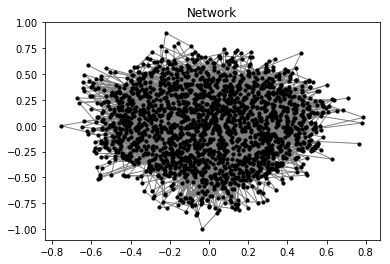

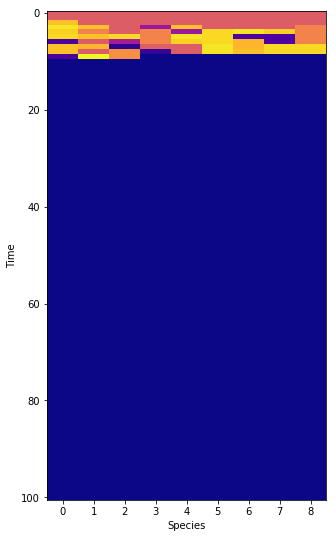

In [145]:
# plot
fig, ax = plt.subplots()
nx.draw_networkx(g, with_labels=False, node_size=10, node_color='black', edge_color='grey')
ax.set_title("Network")

fig, ax = plt.subplots(figsize=(5,9))
ax.imshow(fitness[:,:,0], cmap="plasma", aspect="auto")
ax.set_xlabel("Species")
ax.set_ylabel("Time")

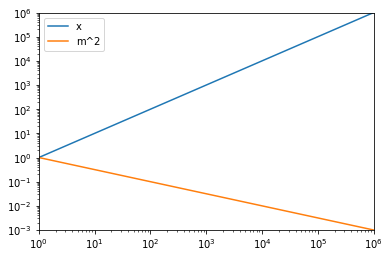

In [10]:
# x = np.linspace(0,1,1000)
x = np.logspace(0, 6, 1e3)
y = np.sqrt(1/x)
plt.plot(x, x, label='x')
# plt.plot(x, 1e6 - x, label='x')
# plt.plot(x, x**(-0.25), label='exp')
# plt.plot(x, 1e6 - y, label='m^2')
# plt.plot(x, y[::-1], label='m^2')
plt.plot(x, y, label='m^2')
# plt.plot(x, np.sqrt(y), label='m^33')
# plt.plot(x, y*x, label='m^3')
# plt.plot(x,x**(-2), label='-2')
plt.semilogy()
plt.semilogx()
plt.margins(0)
plt.legend()